<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/code/01RAD_Ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01RAD Exercise 10
* Multicolinearity
* Regularization in Linear Regression


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from numpy.linalg import cond

import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns

import plotly.express as px

from sklearn import linear_model
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor



### Generate Data Sample

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Generating simple dataset
n = 50  # Sample size
X1 = np.random.normal(10, 2, n)
X2 = np.random.normal(20, 4, n)
X3 = np.random.normal(0, 0.5, n)  # Noise

In [3]:
# Compute new linear dependent variable for collinearity
X4c = 2 * X1  # New variable - collinearity
X4cn = 2 * X1 + X3  # New variable - collinearity + noise

In [4]:
# Compute additional variables for multicollinearity
X5mc = 2 * X1 + X2  # New variable - multicollinearity
X5mcn = 2 * X1 + X2 + X3  # New variable - multicollinearity + noise

In [5]:
# Generating dependent variable
e = np.random.normal(0, 3, n)
Y = 2 * X1 - X2 + e  # without intercept
Y0 = 5 + 2 * X1 - X2 + e  # with intercept


In [6]:
# Forming a DataFrame
mc_data = pd.DataFrame({'Y': Y, 'Y0': Y0, 'X1': X1, 'X2': X2, 'X3': X3, 'X4c': X4c, 'X4cn': X4cn, 'X5mc': X5mc, 'X5mcn': X5mcn})
mc_data.head()

,Y,Y0,X1,X2,X3,X4c,X4cn,X5mc,X5mcn
0,1.441999,6.441999,10.993428,21.296336,-0.707685,21.986857,21.279171,43.283192,42.575507
1,2.026617,7.026617,9.723471,18.459671,-0.210323,19.446943,19.236620,37.906614,37.696291
2,3.258368,8.258368,11.295377,17.292312,-0.171357,22.590754,22.419397,39.883066,39.711709
3,4.342175,9.342175,13.046060,22.446705,-0.401139,26.092119,25.690981,48.538825,48.137686
4,-4.181394,0.818606,9.531693,24.123998,-0.080643,19.063387,18.982744,43.187385,43.106742



### Correlation and correlation matrix

For two real?valued random variables $X$ and $Y$ with finite variance, the
**covariance** is
$$
\operatorname{Cov}(X,Y)
  = \mathbb{E}\big[(X-\mathbb{E}X)(Y-\mathbb{E}Y)\big].
$$

The **correlation coefficient** (Pearson correlation) rescales the
covariance to be dimensionless and bounded in $[-1,1]$:
$$
\rho_{XY}
  = \operatorname{Corr}(X,Y)
  = \frac{\operatorname{Cov}(X,Y)}{\sigma_X\,\sigma_Y},
$$
where $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$.

Given $n$ observations $(x_{i1},\dots,x_{ip})$ of $p$ variables, the
sample covariance between variables $j$ and $k$ is
$$
\widehat{\operatorname{Cov}}(X_j,X_k)
  = \frac{1}{n-1}
    \sum_{i=1}^n (x_{ij} - \bar x_j)(x_{ik} - \bar x_k),
$$
with sample means $\bar x_j$. The **sample correlation** is then
$$
\widehat{\rho}_{jk}
  = \frac{\widehat{\operatorname{Cov}}(X_j,X_k)}{s_j s_k},
$$
where $s_j$ and $s_k$ are the sample standard deviations.

Collecting all pairwise correlations into a matrix yields the
**correlation matrix** $R$:
$$
R = \begin{pmatrix}
 1 & \widehat{\rho}_{12} & \dots  & \widehat{\rho}_{1p} \\
 \widehat{\rho}_{21} & 1 & \dots & \widehat{\rho}_{2p} \\
 \vdots & \vdots & \ddots & \vdots \\
 \widehat{\rho}_{p1} & \widehat{\rho}_{p2} & \dots & 1
\end{pmatrix}.
$$
Large absolute correlations (values close to $\pm 1$) between predictors
are an indicator of potential multicollinearity.


In [7]:
# Detecting collinearity with correlation matrix
correlation_matrix = mc_data.corr().round(2)

# Displaying correlation matrix
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
           Y    Y0    X1    X2    X3   X4c  X4cn  X5mc  X5mcn
Y      1.00  1.00  0.61 -0.59  0.08  0.61  0.62  0.04   0.04
Y0     1.00  1.00  0.61 -0.59  0.08  0.61  0.62  0.04   0.04
X1     0.61  0.61  1.00  0.11 -0.13  1.00  0.99  0.76   0.77
X2    -0.59 -0.59  0.11  1.00 -0.23  0.11  0.08  0.73   0.72
X3     0.08  0.08 -0.13 -0.23  1.00 -0.13  0.01 -0.24  -0.15
X4c    0.61  0.61  1.00  0.11 -0.13  1.00  0.99  0.76   0.77
X4cn   0.62  0.62  0.99  0.08  0.01  0.99  1.00  0.74   0.75
X5mc   0.04  0.04  0.76  0.73 -0.24  0.76  0.74  1.00   1.00
X5mcn  0.04  0.04  0.77  0.72 -0.15  0.77  0.75  1.00   1.00


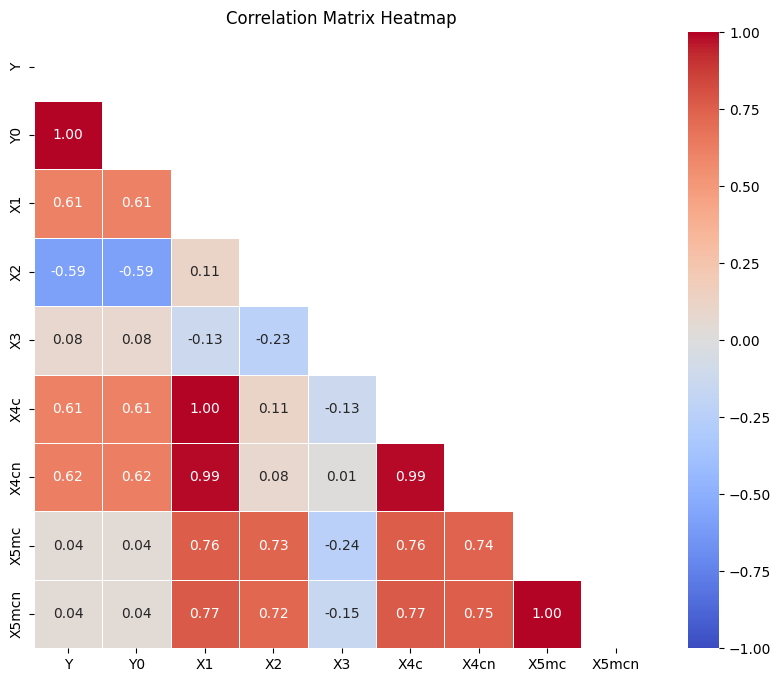

In [8]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f")

# Adding title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


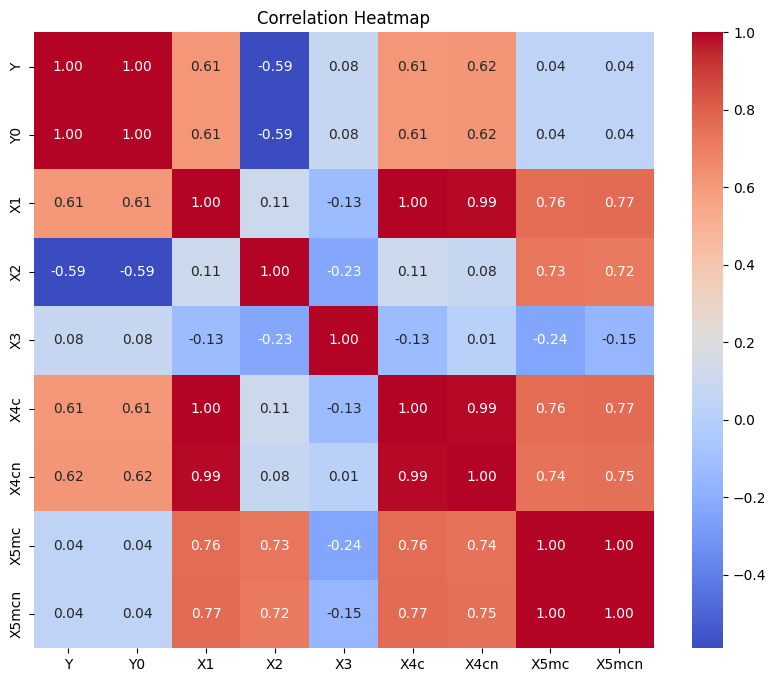

In [9]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [10]:
# Create an interactive heatmap
fig = px.imshow(correlation_matrix, text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.update_layout(title='Interactive Correlation Heatmap')
fig.show()


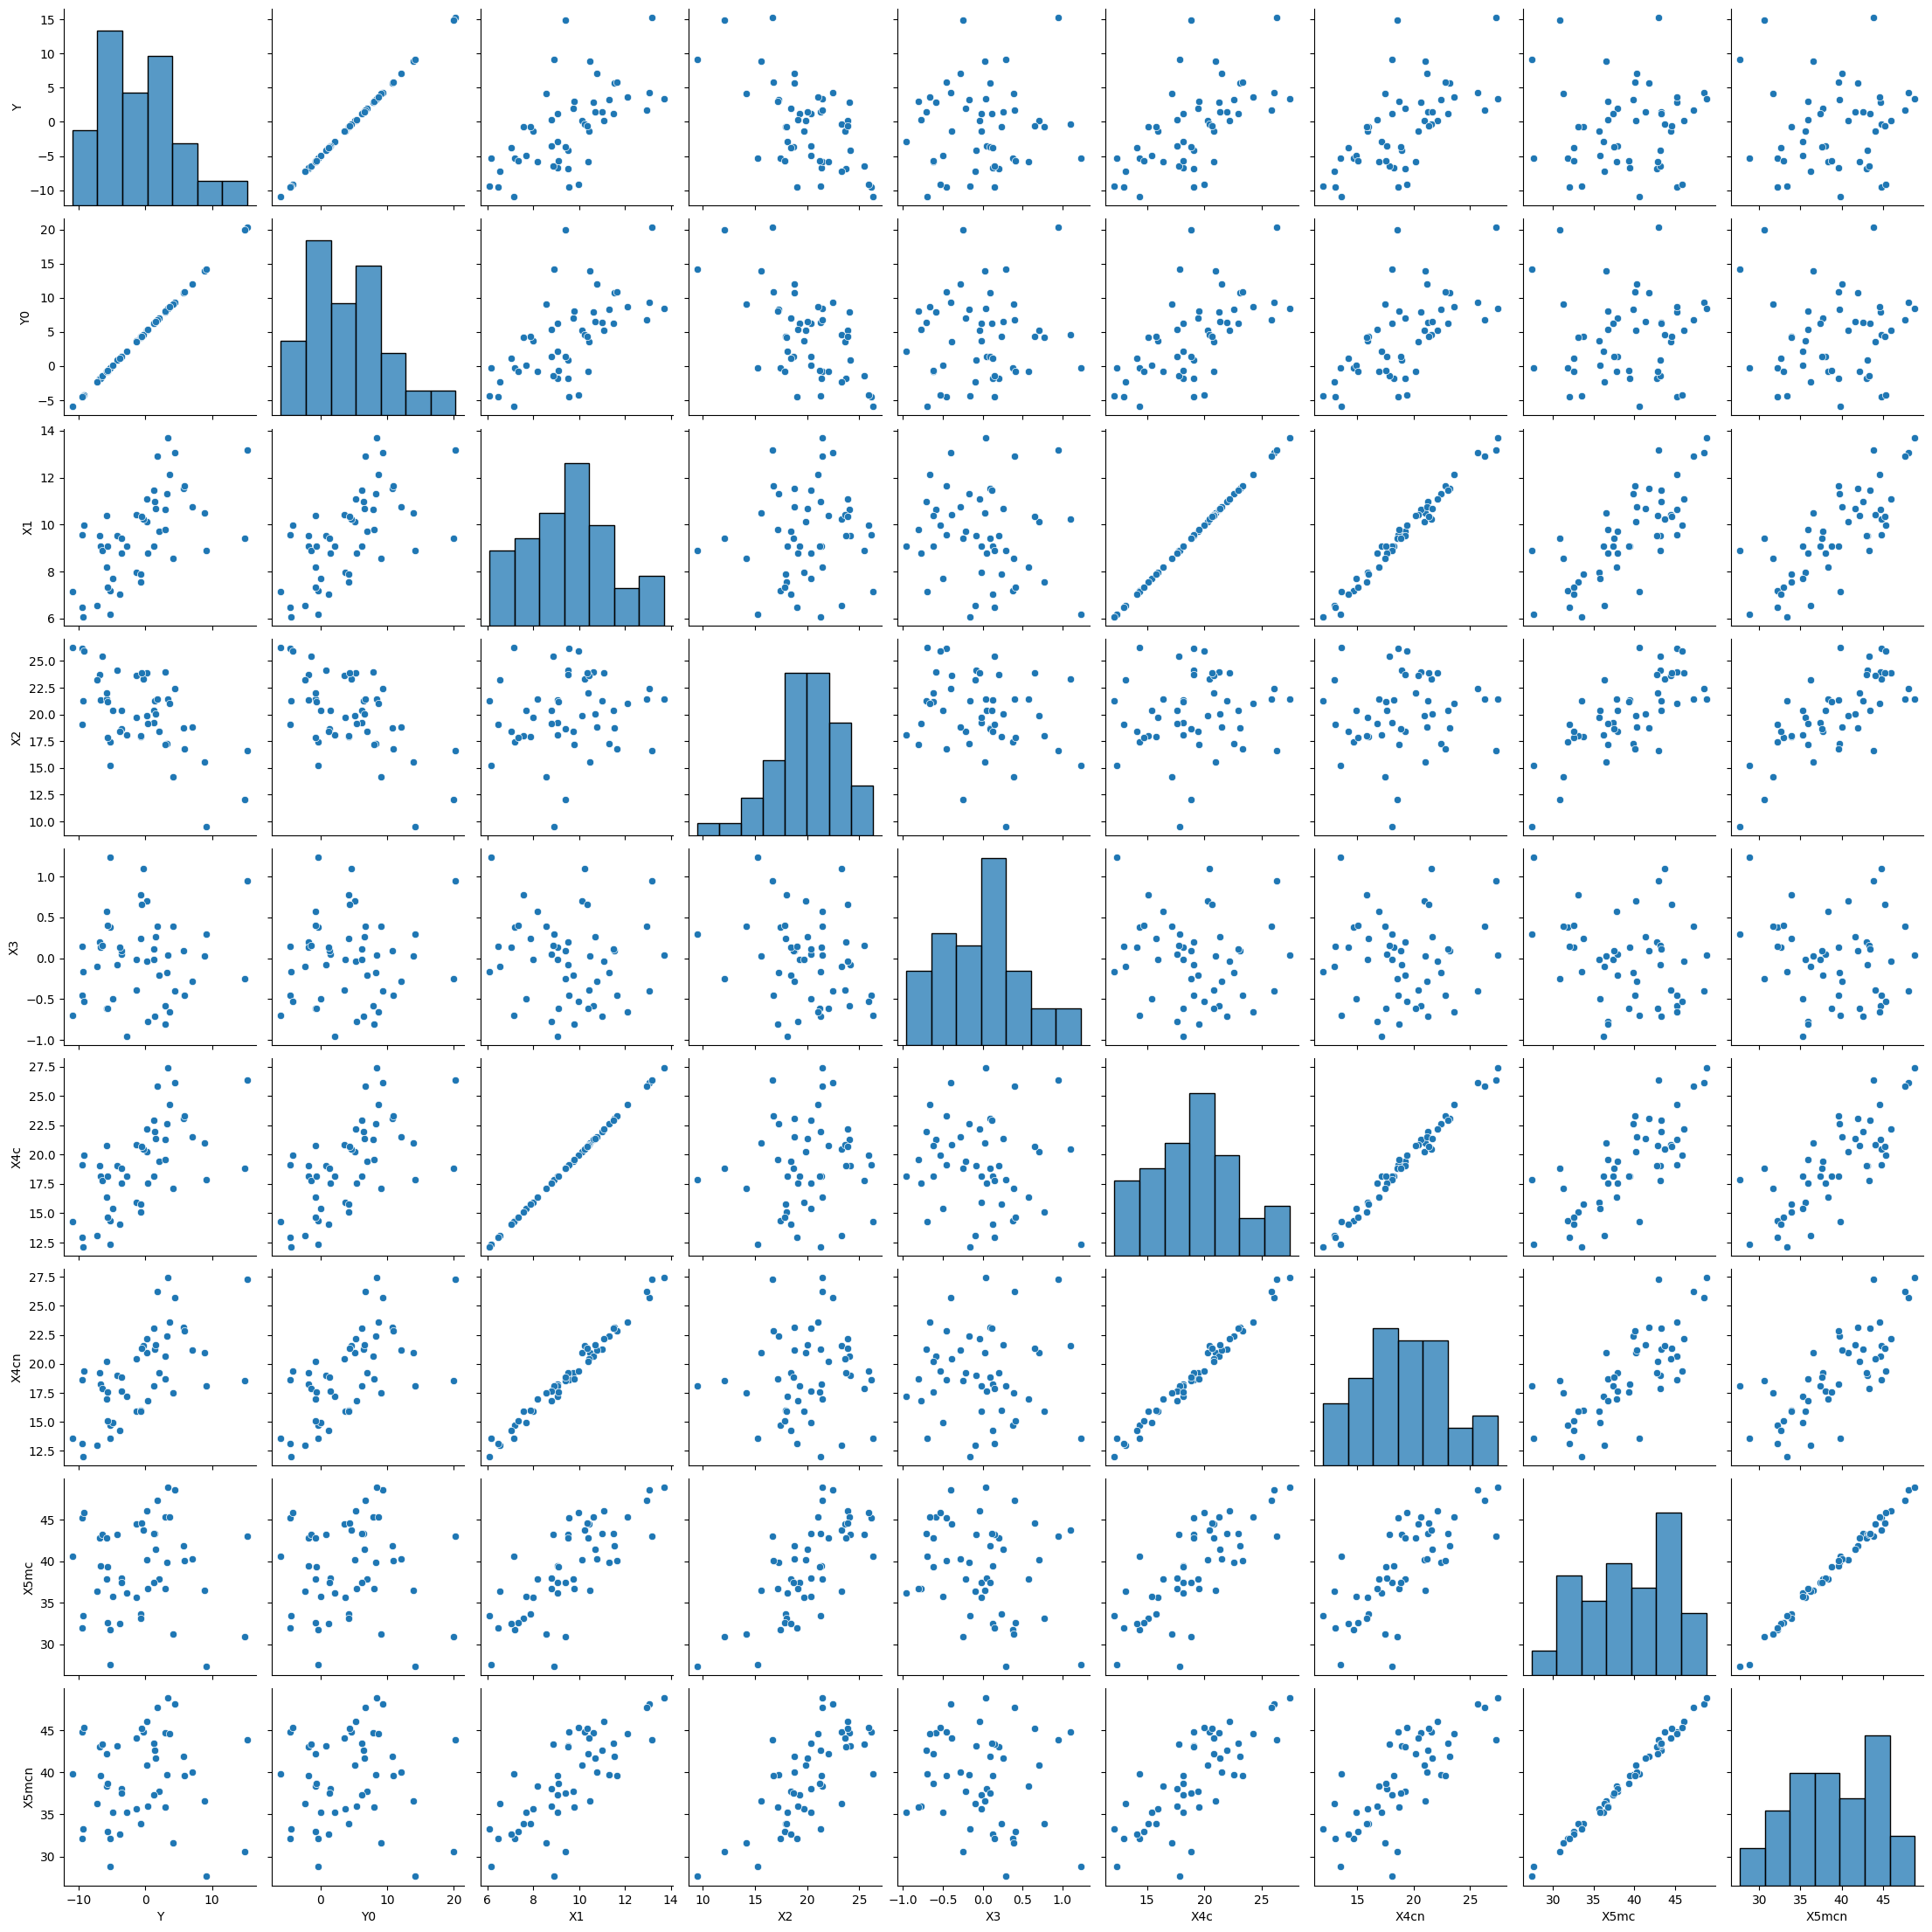

In [11]:
# Pair plot for visual inspection of collinearity
sns.pairplot(mc_data)
plt.show()


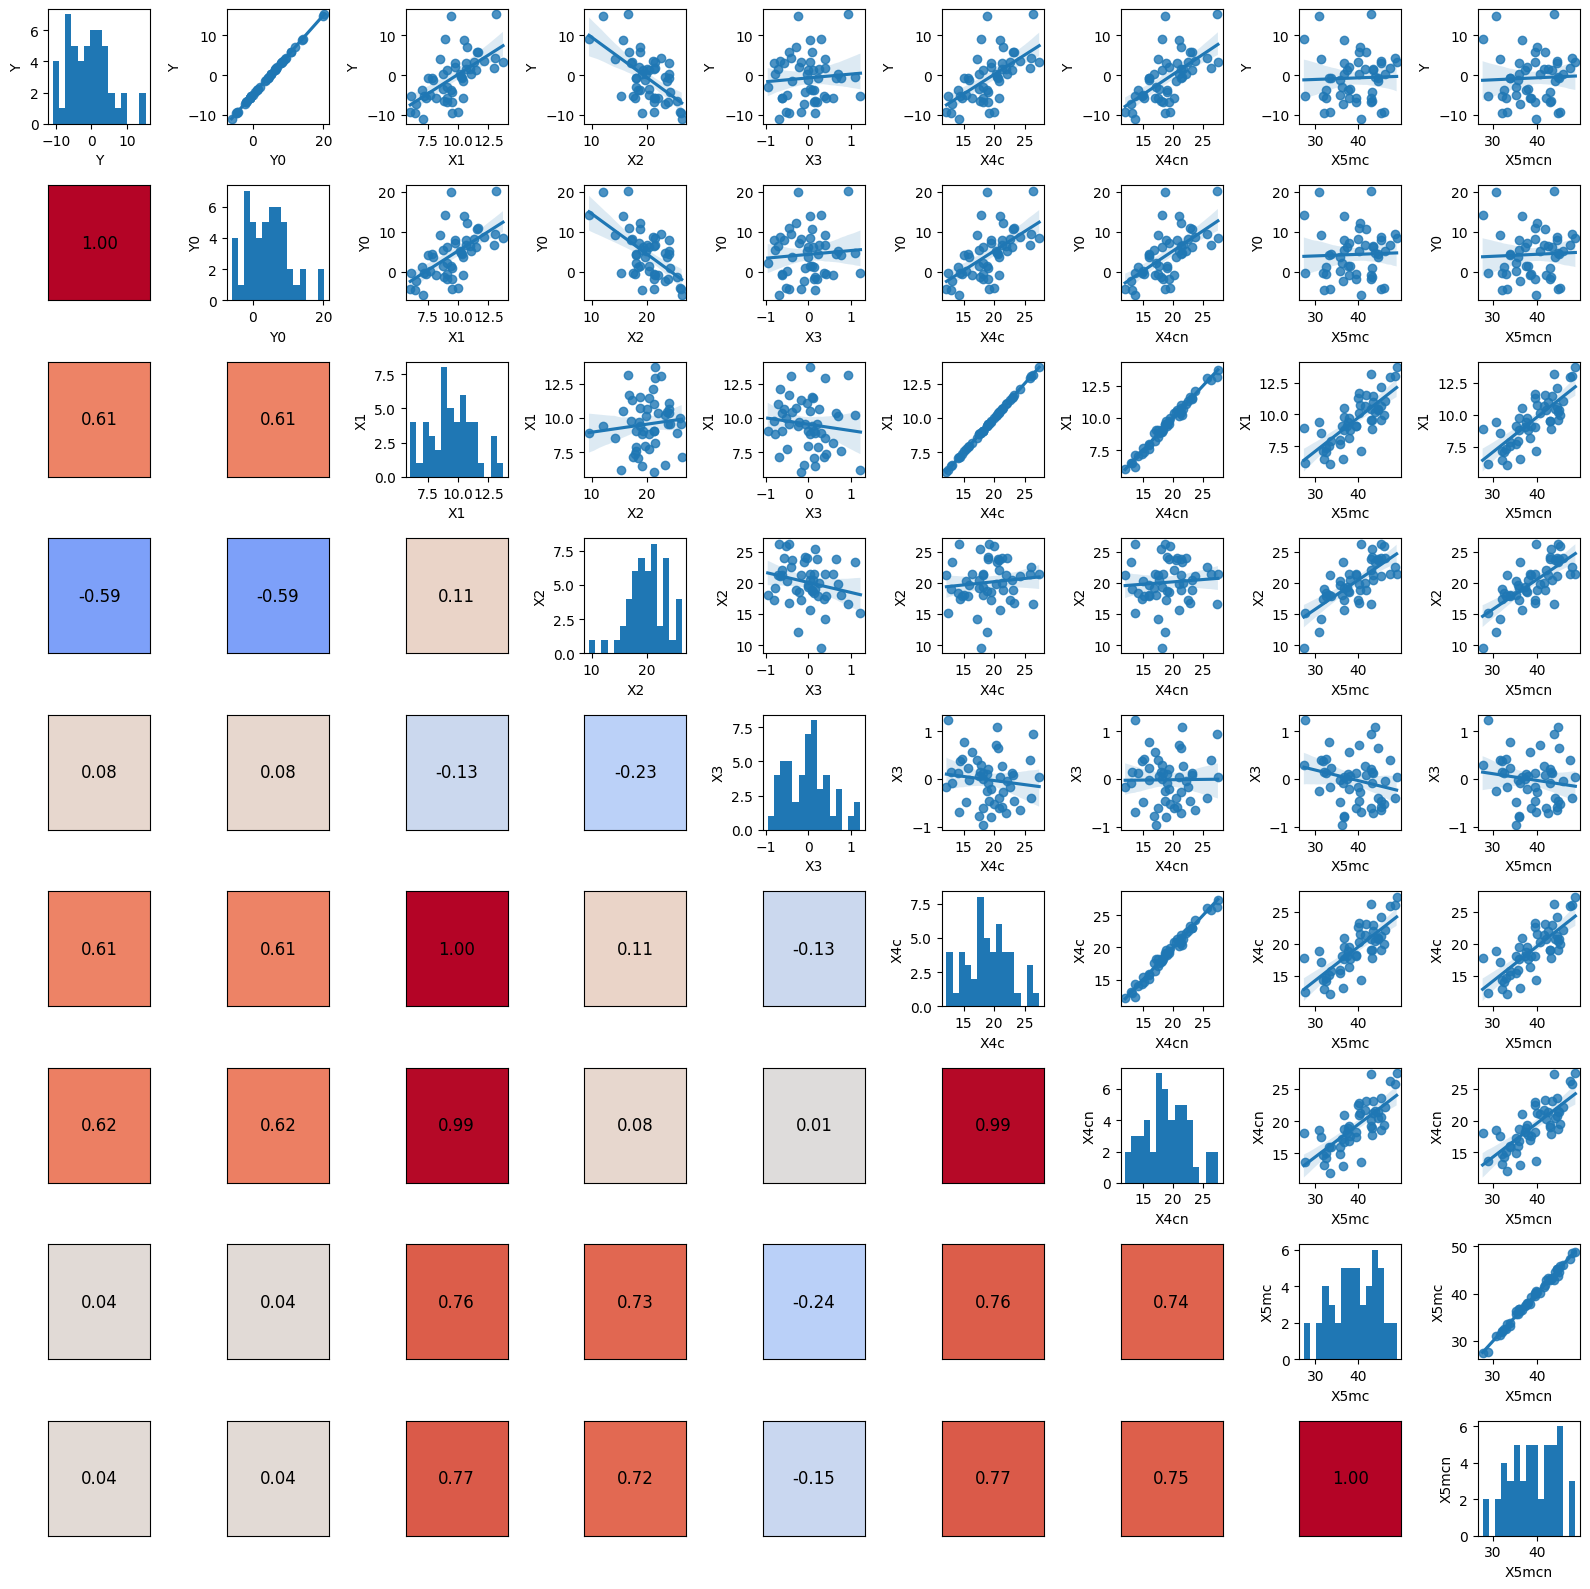

In [12]:
# Get the number of variables
num_vars = len(mc_data.columns)

# Set up the matplotlib figure
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(num_vars, num_vars)

# Loop through rows and columns to create subplots
for i in range(num_vars):
    for j in range(num_vars):
        ax = plt.subplot(gs[i, j])

        # Upper triangle: scatter plot with regression line
        if i < j:
            sns.regplot(x=mc_data.iloc[:, j], y=mc_data.iloc[:, i], ax=ax)

        # Lower triangle: only off-diagonal correlation value
        elif i > j:
            corr_value = mc_data.iloc[:, [i, j]].corr().iloc[0, 1]
            ax.text(0.5, 0.5, f'{corr_value:.2f}', fontsize=12, ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(sns.color_palette("coolwarm", as_cmap=True)(corr_value / 2 + 0.5))  # Color based on corr_value

        # Diagonal: histogram
        elif i == j:
            ax.hist(mc_data.iloc[:, i], bins=15)
            ax.set_xlabel(mc_data.columns[i])
            ax.set_ylabel(mc_data.columns[i])

        # Remove axis if not needed
        else:
            ax.axis('off')

        # Adjust layout
        plt.tight_layout()

# Show the plot
plt.show()


In [13]:
# OLS fit of 2-variable models
Mc1a = smf.ols('Y ~ X1 + X2', data=mc_data).fit()
Mc1a_no_intercept = smf.ols('Y ~ -1 + X1 + X2', data=mc_data).fit()
Mc1a0 = smf.ols('Y0 ~ X1 + X2', data=mc_data).fit()

# OLS fit of 2-variable model using correlated x4cn or 4c instead of x1
Mc1b = smf.ols('Y ~ X2 + X4c', data=mc_data).fit()
Mc1c = smf.ols('Y ~ X2 + X4cn', data=mc_data).fit()

# OLS fit of 3-variable models
Mc2a = smf.ols('Y ~ X1 + X2 + X4c', data=mc_data).fit()
Mc2a_reordered = smf.ols('Y ~ X2 + X4c + X1', data=mc_data).fit()
Mc2an = smf.ols('Y ~ X1 + X2 + X4cn', data=mc_data).fit()

# OLS fit of 4-variable models
Mc3 = smf.ols('Y ~ X1 + X2 + X5mc', data=mc_data).fit()
Mc3n = smf.ols('Y ~ X1 + X2 + X5mcn', data=mc_data).fit()
Mc4a = smf.ols('Y ~ X1 + X5mcn', data=mc_data).fit()
Mc4b = smf.ols('Y ~ X2 + X5mcn', data=mc_data).fit()

# ANOVA comparisons
anova1 = anova_lm(Mc1b, Mc2an)
anova2 = anova_lm(Mc1c, Mc2an)
anova3 = anova_lm(Mc3, Mc1b)
anova4 = anova_lm(Mc3, Mc4a)
anova5 = anova_lm(Mc3, Mc4b)

# Print summaries of selected models
print("Model Mc1a:\n", Mc1a.summary())
print("\nModel Mc2an:\n", Mc2an.summary())

# Print ANOVA results
print("\nANOVA Mc1b vs Mc2an:\n", anova1)
print("\nANOVA Mc1c vs Mc2an:\n", anova2)
print("\nANOVA Mc3 vs Mc1b:\n", anova3)
print("\nANOVA Mc3 vs Mc4a:\n", anova4)
print("\nANOVA Mc3 vs Mc4b:\n", anova5)


Model Mc1a:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     99.40
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           1.30e-17
Time:                        15:59:44   Log-Likelihood:                -118.58
No. Observations:                  50   AIC:                             243.2
Df Residuals:                      47   BIC:                             248.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3774      2.814      0


### Variance Inflation Factor (VIF)

In a linear regression with predictors $X_1,\dots,X_p$ and response $Y$,
multicollinearity arises when one predictor can be well approximated by a
linear combination of the others. The **Variance Inflation Factor (VIF)**
measures how much the variance of the estimated coefficient of a
predictor is inflated due to this collinearity.

For a given predictor $X_j$, regress it on all the remaining predictors:
$$
X_j = \beta_0 + \sum_{k\neq j} \beta_k X_k + u_j,
$$
and let $R_j^2$ be the coefficient of determination of this auxiliary
regression. The VIF for $X_j$ is defined as
$$
\operatorname{VIF}(X_j) = \frac{1}{1 - R_j^2}.
$$

Interpretation:
- $\operatorname{VIF}(X_j) = 1$ means no linear relationship with the
  other predictors.
- Larger values indicate stronger linear dependence; rules of thumb often
  flag VIF values above $5$ or $10$ as problematic.



In [14]:
# Function to calculate VIF
def calculate_vif(df, features):
    X = df[features].copy()  # Create a copy to avoid modifying the original DataFrame
    X['Intercept'] = 1       # Add an intercept for VIF calculation
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data.iloc[:-1]  # Exclude the intercept row from the result

# Compute VIF for the model Y ~ X1 + X2 + X4cn
vif_data1 = calculate_vif(mc_data, ['X1', 'X2', 'X4cn'])
print("VIF for model Y ~ X1 + X2 + X4cn:\n", vif_data1)

# Compute VIF for the model Y ~ X1 + X2
vif_data2 = calculate_vif(mc_data, ['X1', 'X2'])
print("\nVIF for model Y ~ X1 + X2:\n", vif_data2)

# Compute VIF for the model Y ~ X2 + X4cn
vif_data3 = calculate_vif(mc_data, ['X2', 'X4cn'])
print("\nVIF for model Y ~ X2 + X4cn:\n", vif_data3)


VIF for model Y ~ X1 + X2 + X4cn:
   Feature        VIF
0      X1  57.212396
1      X2   1.063902
2    X4cn  56.876746

VIF for model Y ~ X1 + X2:
   Feature       VIF
0      X1  1.012264
1      X2  1.012264

VIF for model Y ~ X2 + X4cn:
   Feature       VIF
0      X2  1.006326
1    X4cn  1.006326


In [15]:
# Manual VIF calculation
def manual_vif(df, feature, other_features):
    model = smf.ols(f'{feature} ~ {" + ".join(other_features)}', data=df).fit()
    rsq = model.rsquared
    return 1 / (1 - rsq)

# Manually compute VIF
vif_X1 = manual_vif(mc_data, 'X1', ['X2', 'X4cn'])
vif_X2 = manual_vif(mc_data, 'X2', ['X1', 'X4cn'])
vif_X4cn = manual_vif(mc_data, 'X4cn', ['X1', 'X2'])

print("\nManual VIF Calculation in model Y ~ X1 + X2 + X4cn")
print("VIF for X1:", vif_X1)
print("VIF for X2:", vif_X2)
print("VIF for X4cn:", vif_X4cn)



Manual VIF Calculation in model Y ~ X1 + X2 + X4cn
VIF for X1: 57.21239623989477
VIF for X2: 1.0639021495629686
VIF for X4cn: 56.87674620884602


In [16]:
# Compute VIF for the model Y ~ X1 + X2 + X5mcn
vif_data4 = calculate_vif(mc_data, ['X1', 'X2', 'X5mcn'])
print("VIF for model Y ~ X1 + X2 + X5mcn:\n", vif_data4)

# Compute VIF for the model Y ~ X1 + X2
vif_data5 = calculate_vif(mc_data, ['X1', 'X2'])
print("\nVIF for model Y ~ X1 + X2:\n", vif_data5)

# Compute VIF for the model Y ~ X2 + X5mcn
vif_data6 = calculate_vif(mc_data, ['X2', 'X5mcn'])
print("\nVIF for model Y ~ X2 + X5mcn:\n", vif_data6)


VIF for model Y ~ X1 + X2 + X5mcn:
   Feature         VIF
0      X1   57.212396
1      X2   48.498932
2   X5mcn  116.059419

VIF for model Y ~ X1 + X2:
   Feature       VIF
0      X1  1.012264
1      X2  1.012264

VIF for model Y ~ X2 + X5mcn:
   Feature      VIF
0      X2  2.05345
1   X5mcn  2.05345


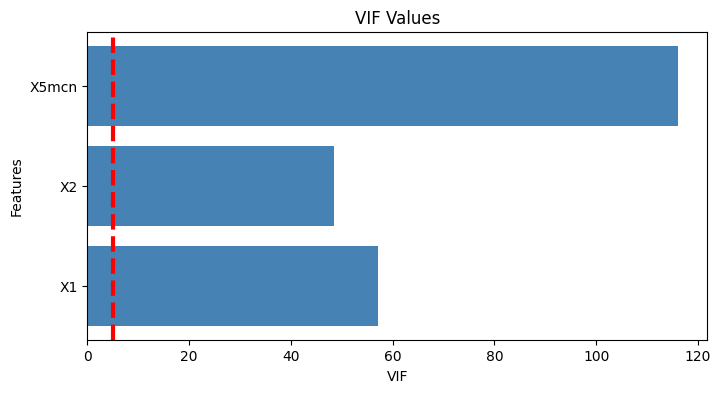

In [17]:
# model Y ~ X1 + X2 + X5mcn
vif_values = vif_data4['VIF']
features = vif_data4['Feature']

plt.figure(figsize=(8, 4))
plt.barh(features, vif_values, color='steelblue')
plt.axvline(x=5, color='red', linestyle='--', linewidth=3)
plt.title("VIF Values")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.show()



### Condition number and multicollinearity

In numerical linear algebra, the **condition number** of a nonsingular
matrix $A$ (with respect to the L2 norm) is defined as
$$
\kappa_2(A) = \lVert A \rVert_2 \; \lVert A^{-1} \rVert_2.
$$
For the L2 norm this can be written using singular values as
$$
\kappa_2(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)},
$$
where $\sigma_{\max}$ and $\sigma_{\min}$ are the largest and smallest
singular values of $A$.

Interpretation:
- $\kappa(A)$ measures how sensitive the solution of a linear system
  $A\beta = b$ is to small perturbations in $A$ or $b$.
- A **well conditioned** matrix has $\kappa(A)$ not much larger than 1;
  a **ill conditioned** matrix has a very large condition number.

In linear regression, the design matrix $X$ (or its scaled/correlation
version) plays the role of $A$. If $X$ has nearly linearly dependent
columns (strong multicollinearity), then the smallest singular value is
close to zero and
$$
\kappa_2(X) = \frac{\sigma_{\max}(X)}{\sigma_{\min}(X)} \gg 1.
$$
Consequences of a large condition number:
- Small changes in the data can lead to large changes in the estimated
  coefficients $\hat\beta$.
- Standard errors are inflated and individual $t$ tests become unstable.



In [18]:
# Direct computation from the regression matrix
cond_number1 = cond(scale(mc_data[['X1', 'X2', 'X4cn']].values))
cond_number2 = cond(scale(mc_data[['X1', 'X2']].values))

# Computing from the correlation matrix
corr_matrix1 = np.corrcoef(mc_data[['X1', 'X2', 'X4cn']].values, rowvar=False)
cond_number3 = cond(corr_matrix1)

corr_matrix2 = np.corrcoef(mc_data[['X1', 'X2']].values, rowvar=False)
cond_number4 = cond(corr_matrix2)

print("Condition Number (X1, X2, X4cn):", cond_number1)
print("Condition Number (X1, X2):", cond_number2)
print("Condition Number from Correlation Matrix (X1, X2, X4cn):", cond_number3)
print("Condition Number from Correlation Matrix (X1, X2):", cond_number4)


Condition Number (X1, X2, X4cn): 15.107642295877906
Condition Number (X1, X2): 1.1168582179858857
Condition Number from Correlation Matrix (X1, X2, X4cn): 228.24085574019904
Condition Number from Correlation Matrix (X1, X2): 1.2473722790826087


In [19]:
# Computing condition number from the correlation matrix
corr_matrix1 = np.corrcoef(mc_data[['X1', 'X2', 'X4cn']].T)
cond_number1 = cond(corr_matrix1)

corr_matrix2 = np.corrcoef(mc_data[['X1', 'X2']].T)
cond_number2 = cond(corr_matrix2)

print("Condition Number from Correlation Matrix (X1, X2, X4cn):", cond_number1)
print("Condition Number from Correlation Matrix (X1, X2):", cond_number2)


Condition Number from Correlation Matrix (X1, X2, X4cn): 228.24085574019904
Condition Number from Correlation Matrix (X1, X2): 1.2473722790826087


In [20]:
# Example linear models (adjust as per your notebook)
# Model 1: Y ~ X1 + X2 + X3 (without intercept)
model1 = smf.ols('Y ~ X1 + X2 + X3 - 1', data=mc_data).fit()

# Model 2: Y0 ~ X1 + X2 + X3 (with intercept)
model2 = smf.ols('Y0 ~ X1 + X2 + X3', data=mc_data).fit()

# Print model summaries
print(model1.summary())
print(model2.summary())

# ANOVA to compare models
anova_results = anova_lm(model1, model2)
print(anova_results)

# Compute VIF for the models
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(model):
    # Extracting the matrix of explanatory variables from the model
    X = model.model.exog
    vif_data = pd.DataFrame()
    vif_data["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    vif_data["Feature"] = model.model.exog_names
    return vif_data

# Calculating VIF for both models
vif_model1 = calculate_vif(model1)
vif_model2 = calculate_vif(model2)

print("VIF for Model 1:\n", vif_model1)
print("VIF for Model 2:\n", vif_model2)

# Manually computing VIF
# Assuming the same models are used, you'll need to compute the correlation matrix
# and then manually calculate the VIF for each variable.


                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.799
Method:                 Least Squares   F-statistic:                              67.23
Date:                Tue, 09 Dec 2025   Prob (F-statistic):                    4.99e-17
Time:                        15:59:44   Log-Likelihood:                         -118.66
No. Observations:                  50   AIC:                                      243.3
Df Residuals:                      47   BIC:                                      249.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [21]:
# Creating a DataFrame from the generated data
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4c': X4c, 'X4cn': X4cn})

# Basic data exploration (similar to summary() in R)
df_describe = df.describe()

# Check for collinearity (Variance Inflation Factor)
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                       for i in range(len(data.columns))]
    return vif_data

# Calculating VIF for the DataFrame
vif_df = calculate_vif(df)

# Displaying results
print("Data Description:\n", df_describe)
print("\nVariance Inflation Factor:\n", vif_df)


Data Description:
               X1         X2         X3        X4c       X4cn
count  50.000000  50.000000  50.000000  50.000000  50.000000
mean    9.549052  20.071123  -0.019644  19.098104  19.078461
std     1.867338   3.497300   0.507707   3.734675   3.705307
min     6.080660   9.521020  -0.959386  12.161320  12.000289
25%     8.278042  18.015555  -0.441305  16.556084  16.848210
50%     9.531710  20.184321   0.008429  19.063419  18.810784
75%    10.672551  22.348296   0.254927  21.345102  21.324076
max    13.704556  26.258575   1.231621  27.409113  27.443394

Variance Inflation Factor:
   feature        VIF
0      X1        inf
1      X2  17.612612
2      X3        inf
3     X4c        inf
4    X4cn        inf


c:\Users\francji1\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



# High Variance vs. High Bias problem

## High Bias
Bias is the algorithm’s tendency to consistently learn the wrong thing by not taking into account all the information in the data (underfitting)

#### Proposals
* Try more complex model.
* Add features (regressors, independent variables)

## High Variance
Variance is the algorithm’s tendency to learn random things irrespective of the real signal by fitting highly flexible models that follow the error/noise in the data too closely (overfitting).

#### Proposals
* Add more training data.
* Try simpler model.
* Remove / reduce some features.
* Add regularization parameters.

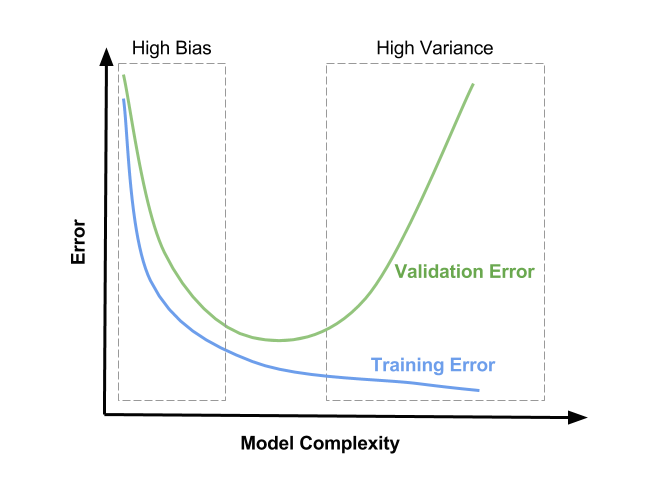


Bias–variance decomposition in linear regression: Use regulariazation techniques such as Lasso, Ridge regression, or Elastic net. Add bias to non-bias OLS estimator to optimize MSE.






### Bias variance trade off and overfitting

When we use a model to predict a response $Y$ from predictors $X$, the
expected prediction error at a point $x$ can be decomposed as
$$
\mathbb{E}\big[(Y - \hat f(x))^2\big]
  = \underbrace{\big(\mathbb{E}[\hat f(x)] - f(x)\big)^2}_{\text{bias}^2}
  + \underbrace{\mathbb{V}[\hat f(x)]}_{\text{variance}}
  + \underbrace{\sigma^2}_{\text{irreducible noise}},
$$
where $f(x) = \mathbb{E}[Y\mid X=x]$ is the true regression function and
$\hat f$ is our fitted model.

- **High bias**: the model is too simple to capture the true structure
  (e.g. fitting a straight line to a strongly curved relationship).
  Predictions are systematically wrong in the same direction   underfit.
- **High variance**: the model is too flexible and adapts strongly to
  random noise in the training data (e.g. very high degree polynomial, a
  tree grown without pruning). Small changes in the training set lead to
  large changes in $\hat f$   overfit.

Model complexity affects this trade off:
- As complexity increases, **bias** usually decreases (the model can fit
  more shapes).
- At the same time, **variance** usually increases (the model can wiggle
  to follow noise).

On a training set, very complex models can drive the training error
close to zero. However, on **test data** the total error
$$
\text{Test MSE} \approx \text{bias}^2 + \text{variance} + \sigma^2
$$
often has a U shaped curve: it first decreases (bias dominates) and then
increases (variance dominates). **Overfitting** corresponds to operating
on the right side of this curve, where an overly complex model achieves
low training error but high test error. Regularization methods such as
ridge and lasso reduce variance by shrinking coefficients, trading a
small increase in bias for a larger reduction in variance.


# From LM to ML: Regularized Regression: Ridge, Lasso, and ElasticNet


### Motivation
In machine learning, regularization is a crucial technique to prevent overfitting and handle collinearity by adding a penalty term to the loss function.

When we have lots of features, we want to be able to penalize their size and number and thus balance the Bias/Variance problem.

Ideally we want to do this by some neat parametrization.






## General Regularized Loss Function

The regularized loss function is given by:

$$
L(\hat{y}, y)_{\text{reg}} = L(\hat{y}, y) + \lambda \cdot R(\beta),
$$

where:
- $ L(\hat{y}, y) $ is the original loss function (e.g., mean squared error for regression tasks),
- $ \lambda $ is the regularization parameter controlling the strength of the penalty,
- $ R(\beta) $ is the regularization term applied to the model coefficients.

---

## Ridge Regression

Ridge regression uses an $ L_2 $-norm penalty to the coefficients and shrinks them continuously toward zero.

### Loss Function

$$
L_{\text{ridge}}(\hat{y}, y) = \| Y - X \beta \|^2 + \lambda \|\beta\|_2^2
$$

where:
- $ \|\beta\|_2^2 = \sum_{j=1}^p \beta_j^2 $.

### Solution

The Ridge regression estimate is given by:

$$
\hat{\beta}_{\text{ridge}} = (X^T X + \lambda I)^{-1} X^T Y.
$$


### Key Properties
- Penalizes large coefficients, reducing multicollinearity.
- Retains all predictors, shrinking them toward zero without setting any to exactly zero.

---

## Lasso Regression

Lasso regression uses an $ L_1 $-norm penalty, where coefficients shrink and some become exactly zero.

### Loss Function

$$
L_{\text{lasso}}(\hat{y}, y) = \| Y - X \beta \|^2 + \lambda \|\beta\|_1,
$$

where:
- $ \|\beta\|_1 = \sum_{j=1}^p |\beta_j| $.

### Solution

Unlike Ridge regression, the solution for Lasso does not have a closed-form expression. It is solved using optimization techniques such as coordinate descent.

### Key Properties
- Lasso is ideal for sparse models with many irrelevant predictors.
- Performs variable selection by setting some coefficients to exactly zero.
- Useful in high-dimensional settings where feature selection is critical.

---

## ElasticNet Regression

ElasticNet combines the $ L_1 $-norm and $ L_2 $-norm penalties, balancing the strengths of Ridge and Lasso regression.

### Loss Function

$$
L_{\text{elasticnet}}(\hat{y}, y) = \| Y - X \beta \|^2 + \lambda \bigg[ \alpha \|\beta\|_1 + \frac{(1-\alpha)}{2} \|\beta\|_2^2 \bigg],
$$

where:
- $ \lambda $ controls the overall strength of the regularization,
- $ \alpha \in [0, 1] $ determines the mixing ratio between Ridge ($ L_2 $) and Lasso ($ L_1 $) penalties:
  - $ \alpha = 1 $: Equivalent to Lasso,
  - $ \alpha = 0 $: Equivalent to Ridge.

### Key Properties
- By tuning  λ  and  α , ElasticNet can be adapted to balance the trade-offs inherent in Ridge and Lasso regression.
- Can handle correlated predictors better than Lasso alone.
- Allows for variable selection while maintaining the Ridge penalty's ability to handle multicollinearity.

---



### Regularized loss function !

$L(\hat{y}, y)_{reg} = L(\hat{y}, y) + \lambda * R(\beta)$.

##### The loss function for ElasticNet regression is
$L(\hat{y}, y)_{lasso} = \sum_{p}{(\hat{y}-y)^2} + \lambda * \big[(1-\alpha)/2\sum_{p}{|\beta|} + \alpha \sum_{p}{\beta ^2}\big]$, where $\lambda \in N, \alpha \in [0, 1]$.

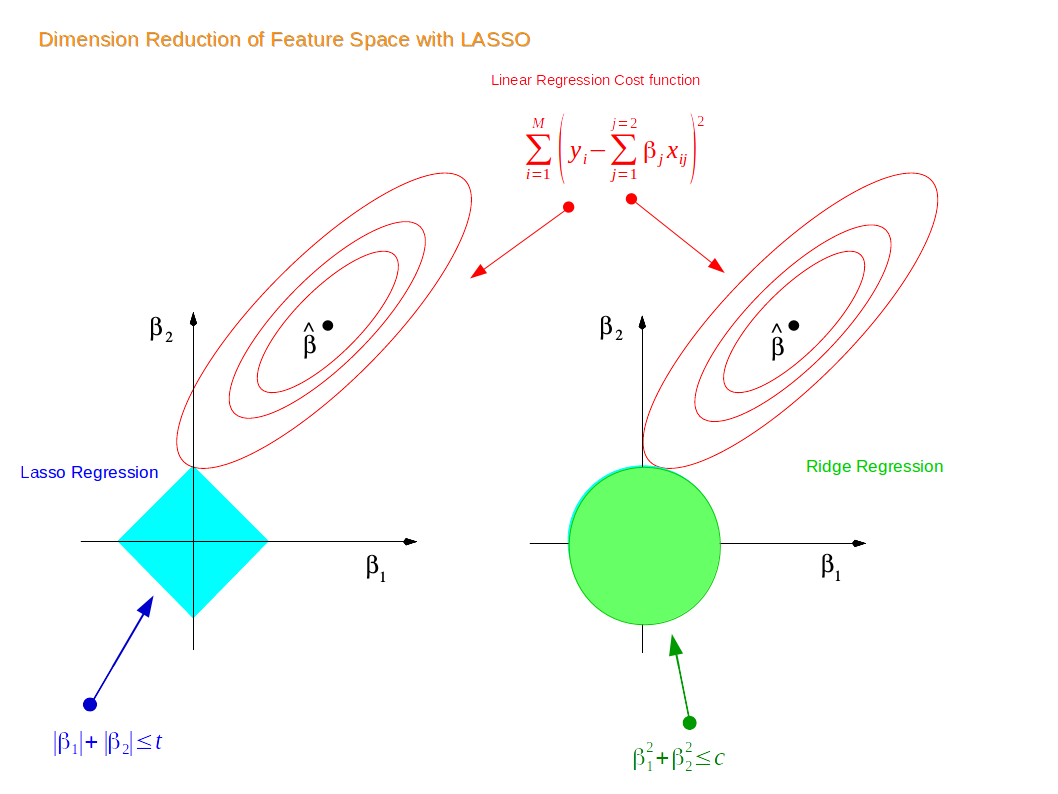



## Code Examples

Python implementation using `sklearn`:
```python
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Lasso Regression
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

# ElasticNet Regression
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)


OLS estimates:   beta_0 = 1.9873634616701894 , beta_1 = 2.942318548441864 , beta_2 = -1.4383176088576457
Ridge estimates: beta_0 = 2.022379213782716 , beta_1 = 1.3829797303639173 , beta_2 = 0.11724886200928623
Lasso estimates: beta_0 = 2.600338250657014 , beta_1 = 1.384393267278582 , beta_2 = 0.0


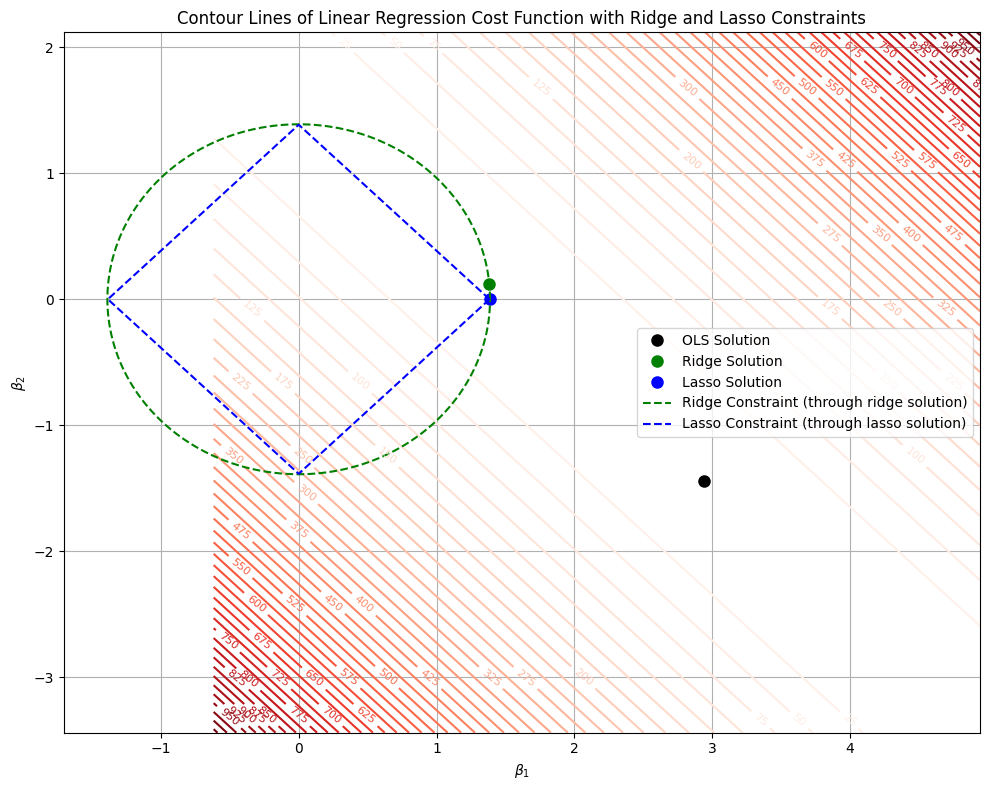

In [22]:

np.random.seed(42)

# Generate synthetic data
N = 100
X1 = np.linspace(0, 10, N)
X2 = np.linspace(0, 10, N)
X2 = X2 + 0.1 * np.random.randn(N)
X = np.column_stack([X1, X2])

beta_0_true = 2.0
beta_1_true = 1.5
beta_2_true = 0.0
y = beta_0_true + beta_1_true * X1 + beta_2_true * X2 + np.random.randn(N)*1.0

# Fit OLS
ols = LinearRegression(fit_intercept=True)
ols.fit(X, y)
b0_ols, b1_ols, b2_ols = ols.intercept_, ols.coef_[0], ols.coef_[1]

# Fit Ridge
ridge = Ridge(alpha=1.0, fit_intercept=True)
ridge.fit(X, y)
b0_ridge, b1_ridge, b2_ridge = ridge.intercept_, ridge.coef_[0], ridge.coef_[1]

# Fit Lasso
lasso = Lasso(alpha=1.0, fit_intercept=True)
lasso.fit(X, y)
b0_lasso, b1_lasso, b2_lasso = lasso.intercept_, lasso.coef_[0], lasso.coef_[1]

print("OLS estimates:   beta_0 =", b0_ols, ", beta_1 =", b1_ols, ", beta_2 =", b2_ols)
print("Ridge estimates: beta_0 =", b0_ridge, ", beta_1 =", b1_ridge, ", beta_2 =", b2_ridge)
print("Lasso estimates: beta_0 =", b0_lasso, ", beta_1 =", b1_lasso, ", beta_2 =", b2_lasso)

# Create a grid of (beta_1, beta_2) values to evaluate the cost function
B1_min = min(b1_ols,b1_ridge,b1_lasso) - 2
B1_max = max(b1_ols,b1_ridge,b1_lasso) + 2
B2_min = min(b2_ols,b2_ridge,b2_lasso) - 2
B2_max = max(b2_ols,b2_ridge,b2_lasso) + 2
B1_range = np.linspace(B1_min, B1_max, 200)
B2_range = np.linspace(B2_min, B2_max, 200)
B1_grid, B2_grid = np.meshgrid(B1_range, B2_range)

def mse_cost(b0, b1, b2, X, y):
    y_pred = b0 + b1*X[:,0] + b2*X[:,1]
    return np.mean((y - y_pred)**2)

# We'll consider contours of the OLS-based cost:
Cost = np.zeros_like(B1_grid)
for i in range(B1_grid.shape[0]):
    for j in range(B1_grid.shape[1]):
        Cost[i,j] = mse_cost(b0_ols, B1_grid[i,j], B2_grid[i,j], X, y)

fig, ax = plt.subplots(figsize=(10,8))
CS = ax.contour(B1_grid, B2_grid, Cost, levels=50, cmap='Reds')
ax.clabel(CS, inline=1, fontsize=8)

# Plot solutions
ax.plot(b1_ols, b2_ols, 'ko', label='OLS Solution', markersize=8)
ax.plot(b1_ridge, b2_ridge, 'go', label='Ridge Solution', markersize=8)
ax.plot(b1_lasso, b2_lasso, 'bo', label='Lasso Solution', markersize=8)

# The ridge penalty corresponds to an L2-ball (circle) around the origin (0,0) in parameter space.
# We set its radius to pass through the ridge solution: radius = sqrt(b1_ridge^2 + b2_ridge^2)
ridge_radius = np.sqrt(b1_ridge**2 + b2_ridge**2)
theta = np.linspace(0, 2*np.pi, 200)
x_ridge = ridge_radius*np.cos(theta)
y_ridge = ridge_radius*np.sin(theta)
ax.plot(x_ridge, y_ridge, 'g--', label='Ridge Constraint (through ridge solution)')

# The lasso penalty corresponds to an L1-ball (diamond) around the origin (0,0).
# We set t = |b1_lasso| + |b2_lasso| to make it pass through the lasso solution.
lasso_t = abs(b1_lasso) + abs(b2_lasso)
# The diamond corners at radius t:
diamond_x = [lasso_t, 0, -lasso_t, 0, lasso_t]
diamond_y = [0, lasso_t, 0, -lasso_t, 0]
ax.plot(diamond_x, diamond_y, 'b--', label='Lasso Constraint (through lasso solution)')

ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\beta_2$')
ax.set_title("Contour Lines of Linear Regression Cost Function with Ridge and Lasso Constraints")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


## Overtraining
* It happens if the complexity of the system we have chosen for training is too large for the given dataset.
* The trained system will adapt to the noise instead of to the class differences.
* The solution is either to enlarge the dataset, but, if not possible, to simplify the system.

How to prevent overtrianing? Good Cross validation.


## Hyperparameter Optimization

In all regularized regression methods, the choice of the regularization parameters ($ \lambda $ and $ \alpha $ for ElasticNet) is crucial. These parameters are typically optimized using techniques such as **Grid Search** or **Random Search** with cross-validation.

### Cross-Validation for Regularized Models

The regularization parameters are tuned to minimize the cross-validated mean squared error:

$$
\text{CV Error} = \frac{1}{K} \sum_{k=1}^K \| y^{(k)} - X^{(k)} \hat{\beta} \|^2,
$$

where $ K $ is the number of folds in $ K $-fold cross-validation.

---



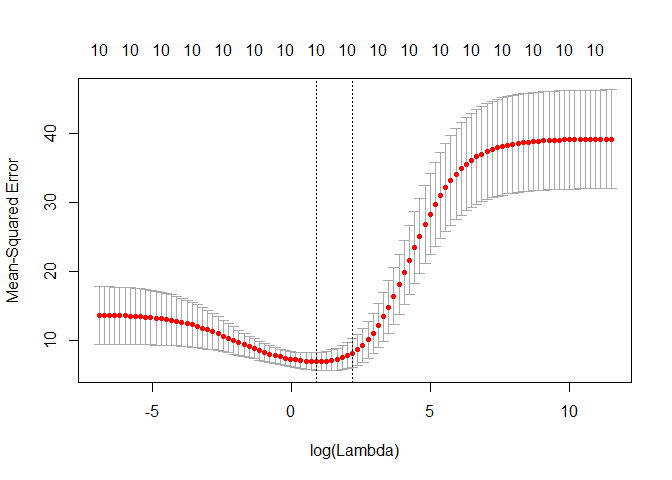



## Cross validation - hyperparameter tunning

Introduction to different cross validation techniques in scikit: https://scikit-learn.org/stable/modules/cross_validation.html

* Train/Validation/Test hold
* K-fold cross-validation, very popular and has become a standard procedure in many papers and works.
* K times K-fold cross-validation, useful for comparing classifiers as the K repeats shrink the standard deviations in the means of the estimated classifier errors.
* K times 2-fold cross-validation helps compute the significance of differences in classification error means.
* Leave-one-out (LOO) cross-validation. In this case the number of folds is equal to the number of objects in the design set.

### K-Fold CV

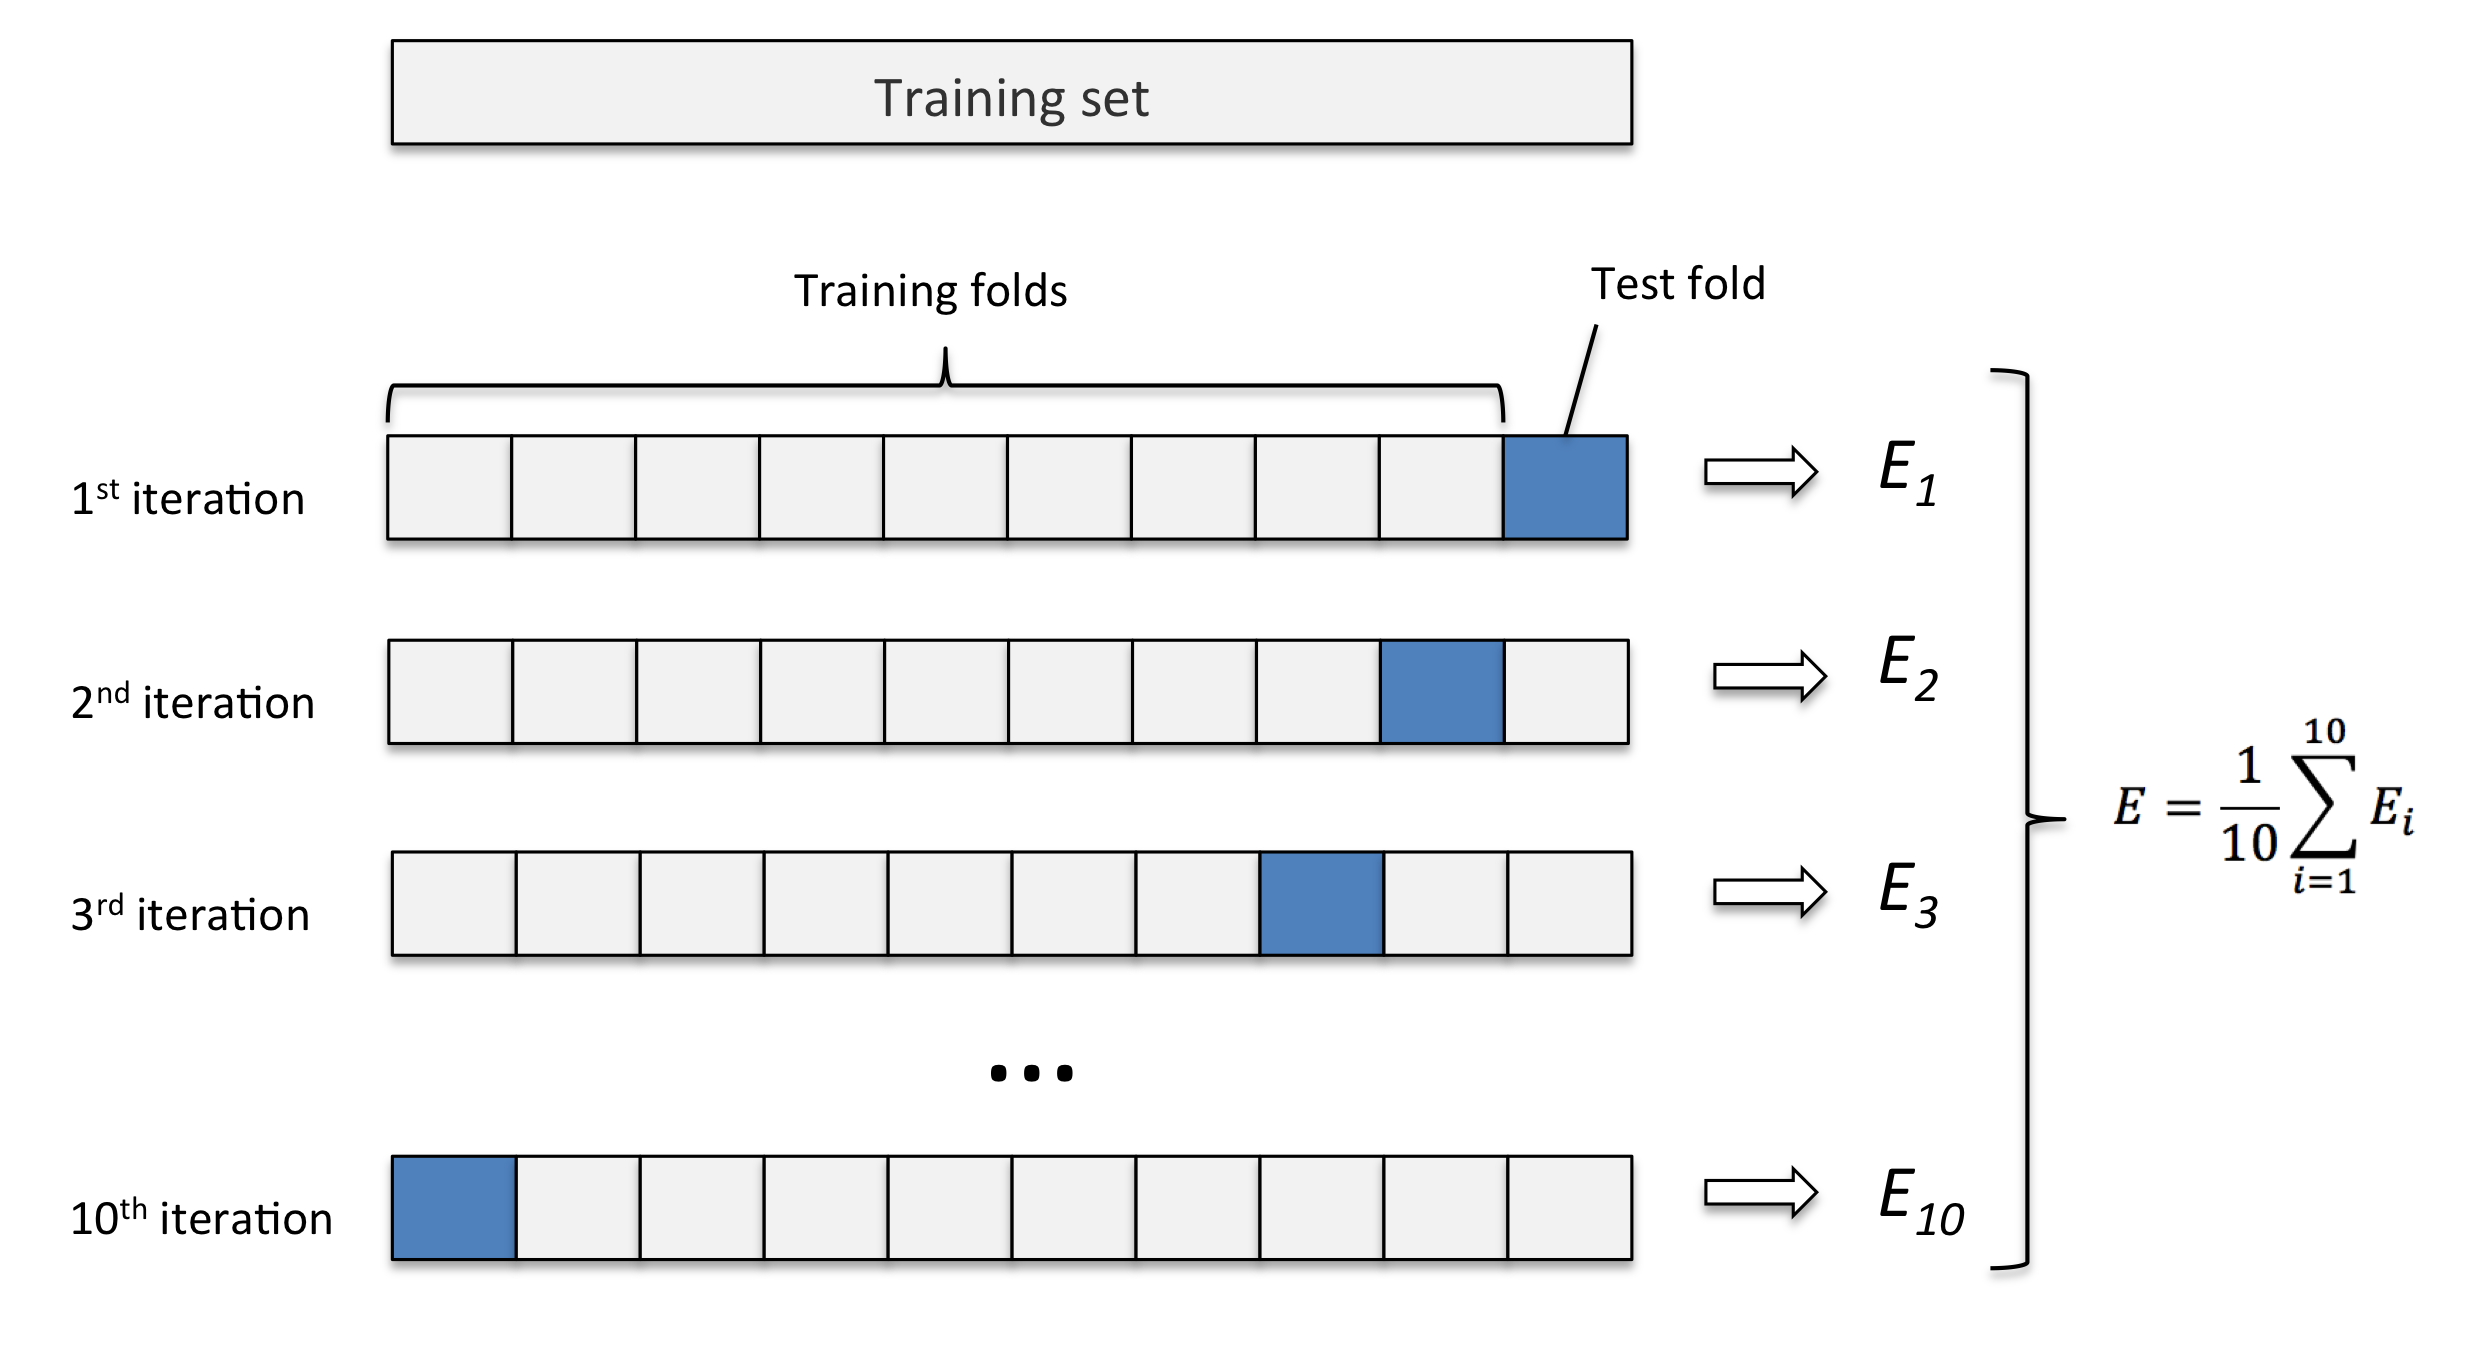



### GridSearch CV Workflow

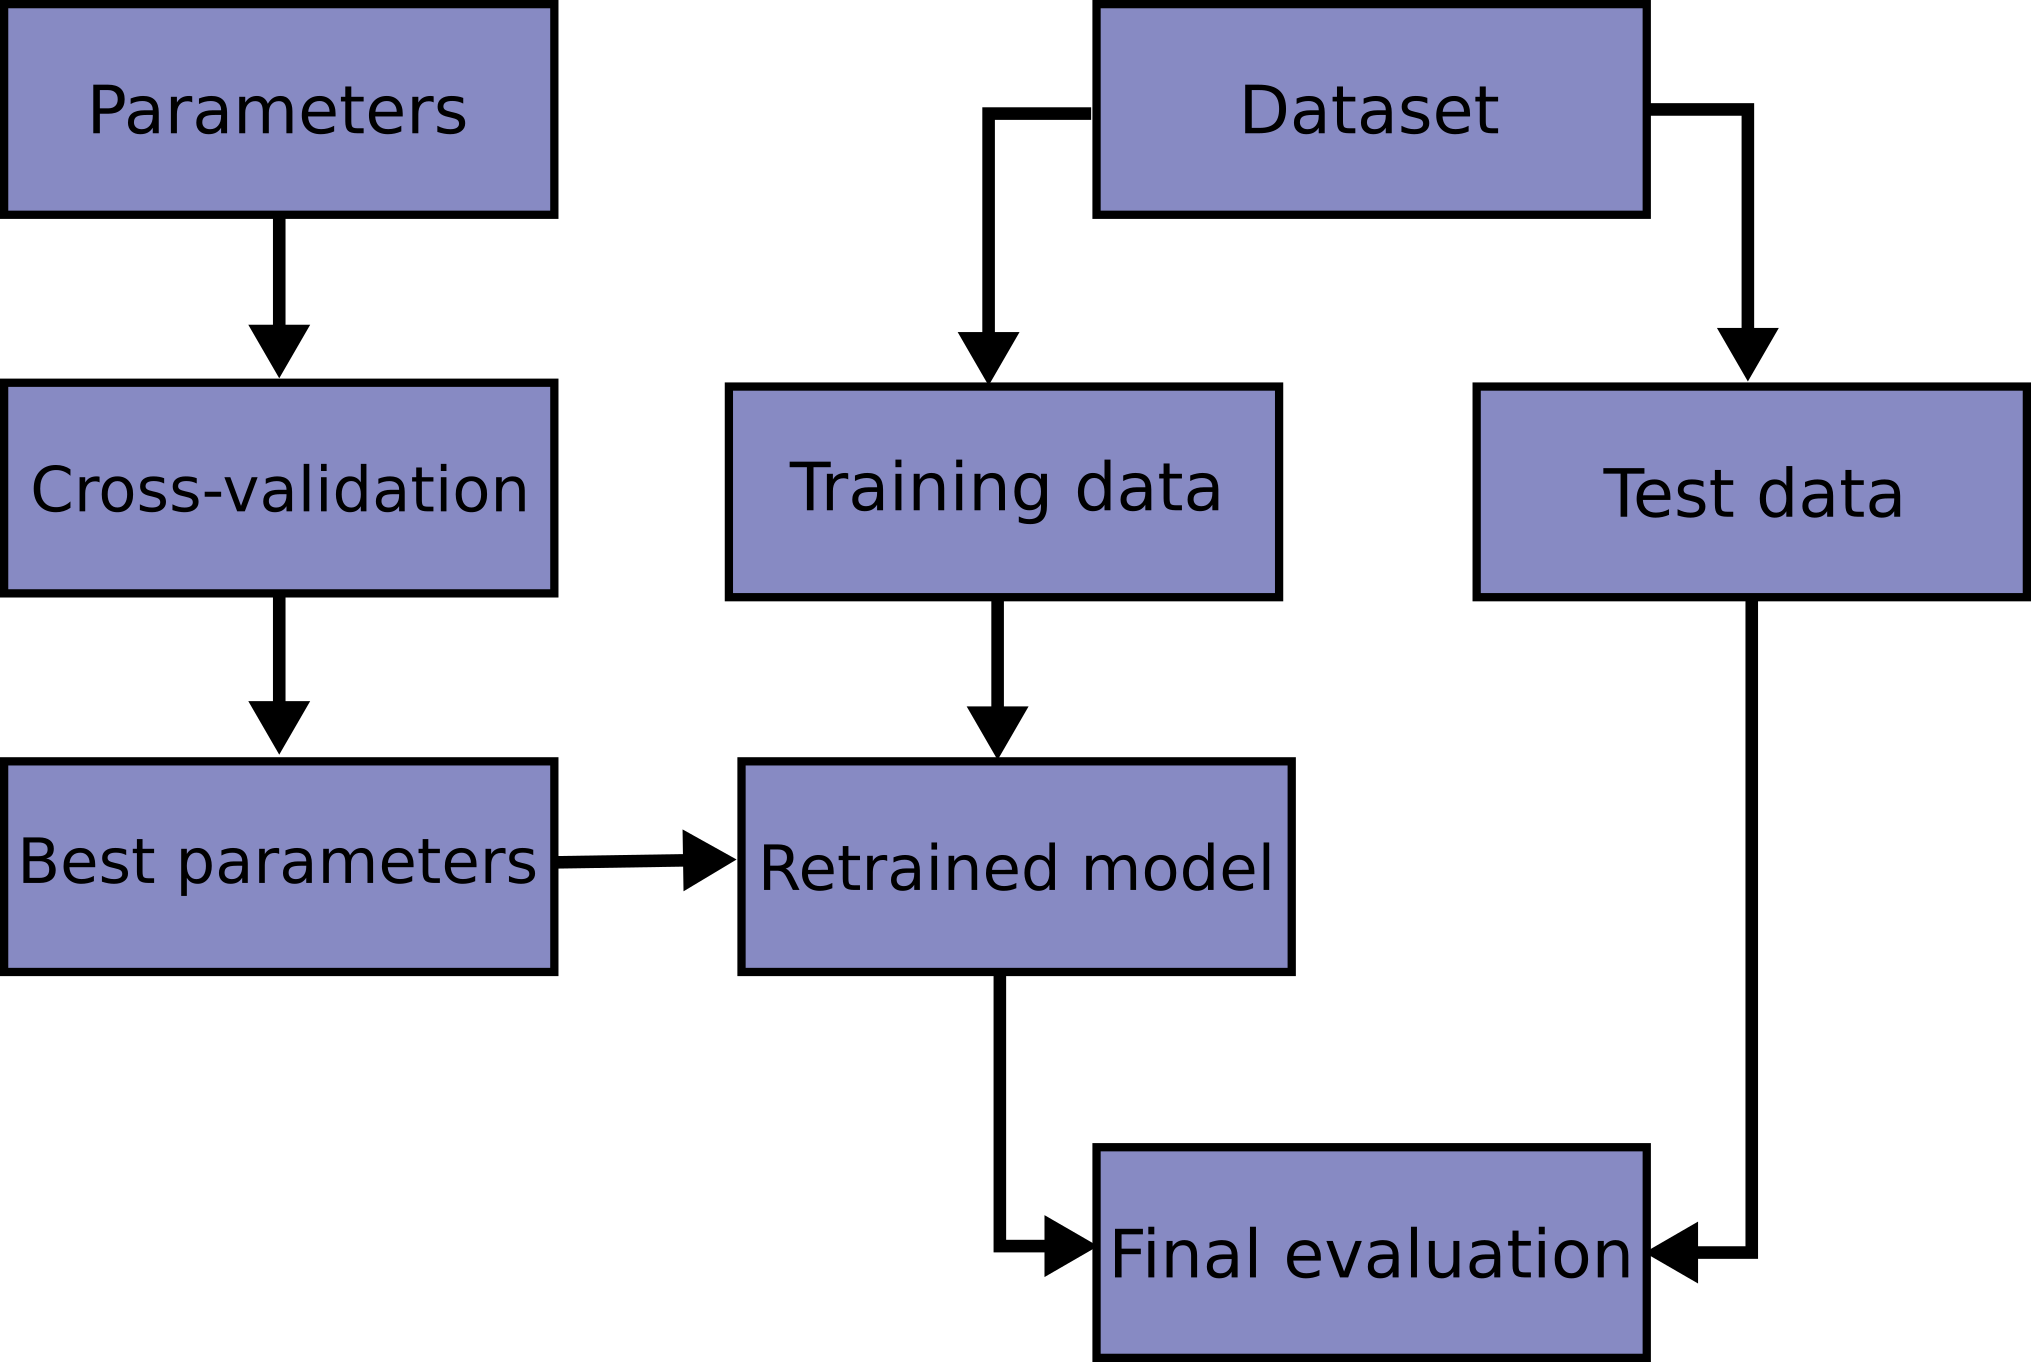

Problems with classic K-fold CV: LEAKING!

With simple K-fold CV we predict on data that we use in training process to adjust our hyperparams!  

Result: The expected error on unseen data is estimated smaller than it should be!!



In [23]:
# Lets continue with mc_data
mc_data.head()

,Y,Y0,X1,X2,X3,X4c,X4cn,X5mc,X5mcn
0,1.441999,6.441999,10.993428,21.296336,-0.707685,21.986857,21.279171,43.283192,42.575507
1,2.026617,7.026617,9.723471,18.459671,-0.210323,19.446943,19.236620,37.906614,37.696291
2,3.258368,8.258368,11.295377,17.292312,-0.171357,22.590754,22.419397,39.883066,39.711709
3,4.342175,9.342175,13.046060,22.446705,-0.401139,26.092119,25.690981,48.538825,48.137686
4,-4.181394,0.818606,9.531693,24.123998,-0.080643,19.063387,18.982744,43.187385,43.106742


In [24]:
X = mc_data.drop(['Y','Y0','X4c','X5mc'], axis=1)  #mc_data.drop(['Y','Y0','X4cn','X5mc','X5mcn'], axis=1)
y = mc_data['Y0']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)


In [25]:
X.head()

,X1,X2,X3,X4cn,X5mcn
0,10.993428,21.296336,-0.707685,21.279171,42.575507
1,9.723471,18.459671,-0.210323,19.236620,37.696291
2,11.295377,17.292312,-0.171357,22.419397,39.711709
3,13.046060,22.446705,-0.401139,25.690981,48.137686
4,9.531693,24.123998,-0.080643,18.982744,43.106742


In [26]:
# Ridge regression with cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-10, 10, 100), cv=5)
ridge_cv.fit(X_train, y_train)

# Coefficients and best alpha
ridge_intercept = ridge_cv.intercept_
ridge_coefficients = ridge_cv.coef_
best_alpha_ridge = ridge_cv.alpha_
print(ridge_intercept)
ridge_coefficients

4.386312870215951


array([ 2.3214437 , -3.59630798, -0.31111549,  2.29721396, -0.76809576])

In [27]:
# Lasso regression with cross-validation
lasso_cv = LassoCV(alphas=np.logspace(-10, 10, 100), cv=5)
lasso_cv.fit(X_train, y_train)

# Coefficients and best alpha
lasso_intercept = lasso_cv.intercept_
lasso_coefficients = lasso_cv.coef_
best_alpha_lasso = lasso_cv.alpha_
print(lasso_intercept)
print(lasso_coefficients)

4.387711906802079
[ 3.74633972 -4.12079367 -0.13602766  0.40710303 -0.04450256]


c:\Users\francji1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+01, tolerance: 1.609e-01



In [28]:
np.random.seed(42)

# Generate data
n = 50
X1 = np.random.normal(10, 2, n)
X2 = np.random.normal(20, 4, n)
X3 = np.random.normal(0, 0.5, n)

X4c = 2 * X1
X4cn = 2 * X1 + X3
X5mc = 2 * X1 + X2
X5mcn = 2 * X1 + X2 + X3

e = np.random.normal(0, 3, n)
Y0 = 5 + 10*X1 - 100*X2 + e  # True model includes Intercept, X1, X2

mc_data = pd.DataFrame({'Y0': Y0, 'X1': X1, 'X2': X2, 'X3': X3,
                        'X4c': X4c, 'X4cn': X4cn, 'X5mc': X5mc, 'X5mcn': X5mcn})

# True coefficients for ALL features used
# If a feature wasn't part of the true model, assign 0.
true_coefs = {
    'Intercept': 5,
    'X1': 10,
    'X2': -100,
    'X3': 0,
    'X4c': 0,
    'X4cn': 0,
    'X5mc': 0,
    'X5mcn': 0
}

features = ['X1', 'X2', 'X3', 'X4c', 'X4cn', 'X5mc', 'X5mcn']
X = mc_data[features].values
y = mc_data['Y0'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [29]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_mean = scaler.mean_
X_std = scaler.scale_

# OLS on scaled data
X_train_ols = sm.add_constant(X_train_scaled)
X_test_ols = sm.add_constant(X_test_scaled)
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_scaled, y_train)

# ElasticNet
enet = ElasticNet(alpha=1.0, l1_ratio=0.5)
enet.fit(X_train_scaled, y_train)


,alpha,1.0
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [30]:
# Extract scaled parameters
ols_scaled_params = ols_model.params
ols_intercept_scaled = ols_scaled_params[0]
ols_coefs_scaled = ols_scaled_params[1:]

ridge_intercept_scaled = ridge.intercept_
ridge_coefs_scaled = ridge.coef_

lasso_intercept_scaled = lasso.intercept_
lasso_coefs_scaled = lasso.coef_

enet_intercept_scaled = enet.intercept_
enet_coefs_scaled = enet.coef_

def revert_scaling(intercept_scaled, coefs_scaled, X_mean, X_std):
    coefs_original = coefs_scaled / X_std
    intercept_original = intercept_scaled - np.sum((coefs_scaled * X_mean) / X_std)
    return intercept_original, coefs_original

# Revert scaling for all models
ols_intercept_orig, ols_coefs_orig = revert_scaling(ols_intercept_scaled, ols_coefs_scaled, X_mean, X_std)
ridge_intercept_orig, ridge_coefs_orig = revert_scaling(ridge_intercept_scaled, ridge_coefs_scaled, X_mean, X_std)
lasso_intercept_orig, lasso_coefs_orig = revert_scaling(lasso_intercept_scaled, lasso_coefs_scaled, X_mean, X_std)
enet_intercept_orig, enet_coefs_orig = revert_scaling(enet_intercept_scaled, enet_coefs_scaled, X_mean, X_std)

coef_index = ['Intercept'] + features

comparison_df = pd.DataFrame({
    'True': [
        true_coefs['Intercept'], true_coefs['X1'], true_coefs['X2'], true_coefs['X3'],
        true_coefs['X4c'], true_coefs['X4cn'], true_coefs['X5mc'], true_coefs['X5mcn']
    ],
    'OLS_scaled': [ols_intercept_scaled] + list(ols_coefs_scaled),
    'OLS_original': [ols_intercept_orig] + list(ols_coefs_orig),
    'Ridge_scaled': [ridge_intercept_scaled] + list(ridge_coefs_scaled),
    'Ridge_original': [ridge_intercept_orig] + list(ridge_coefs_orig),
    'Lasso_scaled': [lasso_intercept_scaled] + list(lasso_coefs_scaled),
    'Lasso_original': [lasso_intercept_orig] + list(lasso_coefs_orig),
    'ElasticNet_scaled': [enet_intercept_scaled] + list(enet_coefs_scaled),
    'ElasticNet_original': [enet_intercept_orig] + list(enet_coefs_orig)
}, index=coef_index)

print("Coefficient Comparison:")
print(comparison_df)


Coefficient Comparison:
           True   OLS_scaled  OLS_original  Ridge_scaled  Ridge_original  \
Intercept     5 -1902.920691      8.381669  -1902.920691      -15.572126   
X1           10    56.001824     29.476340     54.853715       28.872038   
X2         -100  -208.770652    -60.990718   -205.465798      -60.025230   
X3            0     2.364046      5.395940      2.958269        6.752255   
X4c           0    56.001824     14.738170     54.853715       14.436019   
X4cn          0    56.170171     14.755095     55.092575       14.472026   
X5mc          0   -98.868974    -19.479038    -97.499710      -19.209268   
X5mcn         0   -99.366210    -19.716153    -97.935557      -19.432284   

           Lasso_scaled  Lasso_original  ElasticNet_scaled  \
Intercept  -1902.920691        7.655296       -1902.920691   
X1            18.091326        9.522299          38.512706   
X2          -341.976015      -99.905626        -158.542579   
X3             0.000000        0.000000    

In [31]:
np.random.seed(42)

# Generate data
n = 50
X1 = np.random.normal(10, 2, n)
X2 = np.random.normal(20, 4, n)
X3 = np.random.normal(0, 0.5, n)

X4c = 2 * X1
X4cn = 2 * X1 + X3
X5mc = 2 * X1 + X2
X5mcn = 2 * X1 + X2 + X3

e = np.random.normal(0, 3, n)
Y0 = 5 + 10*X1 - 100*X2 + e  # True model: Intercept=5, X1=10, X2=-100, others=0

mc_data = pd.DataFrame({'Y0': Y0, 'X1': X1, 'X2': X2, 'X3': X3,
                        'X4c': X4c, 'X4cn': X4cn, 'X5mc': X5mc, 'X5mcn': X5mcn})

true_coefs = {
    'Intercept': 5,
    'X1': 10,
    'X2': -100,
    'X3': 0,
    'X4c': 0,
    'X4cn': 0,
    'X5mc': 0,
    'X5mcn': 0
}

features = ['X1', 'X2', 'X3', 'X4c', 'X4cn', 'X5mc', 'X5mcn']
X = mc_data[features].values
y = mc_data['Y0'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_mean = scaler.mean_
X_std = scaler.scale_

# OLS on scaled features
X_train_ols = sm.add_constant(X_train_scaled)
ols_model = sm.OLS(y_train, X_train_ols).fit()
ols_scaled_params = ols_model.params
ols_intercept_scaled = ols_scaled_params[0]
ols_coefs_scaled = ols_scaled_params[1:]

# Cross-validated Ridge
ridge_cv = RidgeCV(alphas=np.logspace(-2, 2, 20), cv=5)
ridge_cv.fit(X_train_scaled, y_train)
ridge_intercept_scaled = ridge_cv.intercept_
ridge_coefs_scaled = ridge_cv.coef_

# Cross-validated Lasso
lasso_cv = LassoCV(alphas=np.logspace(-2, 2, 20), cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
lasso_intercept_scaled = lasso_cv.intercept_
lasso_coefs_scaled = lasso_cv.coef_

# Cross-validated ElasticNet
enet_cv = ElasticNetCV(alphas=np.logspace(-2, 2, 20), l1_ratio=[0.1,0.5,0.9], cv=5, max_iter=10000)
enet_cv.fit(X_train_scaled, y_train)
enet_intercept_scaled = enet_cv.intercept_
enet_coefs_scaled = enet_cv.coef_

def revert_scaling(intercept_scaled, coefs_scaled, X_mean, X_std):
    coefs_original = coefs_scaled / X_std
    intercept_original = intercept_scaled - np.sum((coefs_scaled * X_mean) / X_std)
    return intercept_original, coefs_original

ols_intercept_orig, ols_coefs_orig = revert_scaling(ols_intercept_scaled, ols_coefs_scaled, X_mean, X_std)
ridge_intercept_orig, ridge_coefs_orig = revert_scaling(ridge_intercept_scaled, ridge_coefs_scaled, X_mean, X_std)
lasso_intercept_orig, lasso_coefs_orig = revert_scaling(lasso_intercept_scaled, lasso_coefs_scaled, X_mean, X_std)
enet_intercept_orig, enet_coefs_orig = revert_scaling(enet_intercept_scaled, enet_coefs_scaled, X_mean, X_std)

coef_index = ['Intercept'] + features

comparison_df = pd.DataFrame({
    'True': [
        true_coefs['Intercept'], true_coefs['X1'], true_coefs['X2'], true_coefs['X3'],
        true_coefs['X4c'], true_coefs['X4cn'], true_coefs['X5mc'], true_coefs['X5mcn']
    ],
    'OLS_scaled': [ols_intercept_scaled] + list(ols_coefs_scaled),
    'OLS_original': [ols_intercept_orig] + list(ols_coefs_orig),
    'Ridge_scaled': [ridge_intercept_scaled] + list(ridge_coefs_scaled),
    'Ridge_original': [ridge_intercept_orig] + list(ridge_coefs_orig),
    'Lasso_scaled': [lasso_intercept_scaled] + list(lasso_coefs_scaled),
    'Lasso_original': [lasso_intercept_orig] + list(lasso_coefs_orig),
    'ElasticNet_scaled': [enet_intercept_scaled] + list(enet_coefs_scaled),
    'ElasticNet_original': [enet_intercept_orig] + list(enet_coefs_orig)
}, index=coef_index)

print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Best alpha for Lasso:", lasso_cv.alpha_)
print("Best alpha for ElasticNet:", enet_cv.alpha_, "with l1_ratio =", enet_cv.l1_ratio_)

print("\nCoefficient Comparison:")
print(comparison_df)

# Evaluate on test data
X_test_ols = sm.add_constant(X_test_scaled)
ols_preds = ols_model.predict(X_test_ols)
ridge_preds = ridge_cv.predict(X_test_scaled)
lasso_preds = lasso_cv.predict(X_test_scaled)
enet_preds = enet_cv.predict(X_test_scaled)

print("\nTest MSE:")
print("OLS MSE:", mean_squared_error(y_test, ols_preds))
print("Ridge MSE:", mean_squared_error(y_test, ridge_preds))
print("Lasso MSE:", mean_squared_error(y_test, lasso_preds))
print("ElasticNet MSE:", mean_squared_error(y_test, enet_preds))


Best alpha for Ridge: 0.01
Best alpha for Lasso: 0.01
Best alpha for ElasticNet: 0.01 with l1_ratio = 0.9

Coefficient Comparison:
           True   OLS_scaled  OLS_original  Ridge_scaled  Ridge_original  \
Intercept     5 -1902.920691      8.381669  -1902.920691        8.138505   
X1           10    56.001824     29.476340     55.990134       29.470187   
X2         -100  -208.770652    -60.990718   -208.737057      -60.980903   
X3            0     2.364046      5.395940      2.370242        5.410083   
X4c           0    56.001824     14.738170     55.990134       14.735094   
X4cn          0    56.170171     14.755095     56.159215       14.752217   
X5mc          0   -98.868974    -19.479038    -98.855070      -19.476299   
X5mcn         0   -99.366210    -19.716153    -99.351668      -19.713268   

           Lasso_scaled  Lasso_original  ElasticNet_scaled  \
Intercept  -1902.920691        8.306256       -1902.920691   
X1            24.312633       12.796859          64.751670  

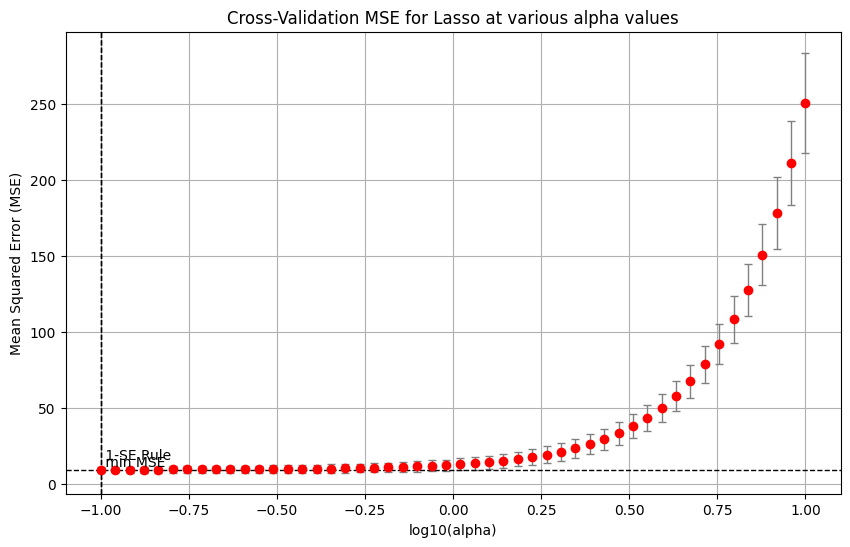

In [32]:
# Run LassoCV to determine best alpha
lasso_cv = LassoCV(alphas=np.logspace(-1, 1, 50), cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

alphas = lasso_cv.alphas_              # array of alphas tested
mse_path = lasso_cv.mse_path_          # shape (n_alphas, n_folds)

# Compute mean and std error
mse_mean = mse_path.mean(axis=1)
mse_std = mse_path.std(axis=1, ddof=1) / np.sqrt(mse_path.shape[1])  # std error

# Identify alpha that gives minimum mean MSE
min_idx = np.argmin(mse_mean)
alpha_min = alphas[min_idx]
mse_min = mse_mean[min_idx]

# Compute 1-SE rule alpha (largest alpha within 1 std error of min MSE)
threshold = mse_min + mse_std[min_idx]
candidates = np.where(mse_mean <= threshold)[0]
alpha_1se = alphas[candidates[-1]]

# Plot the MSE with error bars
plt.figure(figsize=(10,6))
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_std, fmt='o', color='red', ecolor='gray', elinewidth=1, capsize=3)
plt.axhline(y=mse_min, color='black', linestyle='--', linewidth=1) # horizontal line at min MSE

# Vertical lines at alpha_min and alpha_1se
plt.axvline(x=np.log10(alpha_min), color='black', linestyle='--', linewidth=1)
plt.axvline(x=np.log10(alpha_1se), color='black', linestyle='--', linewidth=1)

plt.xlabel('log10(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Cross-Validation MSE for Lasso at various alpha values')

# Annotate alpha_min and alpha_1se
plt.text(np.log10(alpha_min), mse_min, ' min MSE', horizontalalignment='left', verticalalignment='bottom')
plt.text(np.log10(alpha_1se), mse_min+5, ' 1-SE Rule', horizontalalignment='left', verticalalignment='bottom')

plt.grid(True)
plt.show()


In [33]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

# Generate example data
np.random.seed(42)
n = 100
X_num = np.random.rand(n, 2)  # two numeric features
X_cat = np.random.choice(['A','B','C'], size=(n,1))  # one categorical feature

y = 5 + 10*X_num[:,0] - 3*X_num[:,1] + np.where(X_cat.ravel()=='A',0,5) + np.random.randn(n)*2.0

df = pd.DataFrame(np.hstack([X_num, X_cat]), columns=['num1','num2','cat'])
df['num1'] = df['num1'].astype(float)
df['num2'] = df['num2'].astype(float)

X = df[['num1','num2','cat']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_include=object)

pipeline_preprocess = ColumnTransformer(transformers=[
    ('numerical_preprocessing', num_transformer, num_selector),
    ('categorical_preprocessing', cat_transformer, cat_selector)],
    remainder='passthrough')

pipe = Pipeline([("transform_inputs", pipeline_preprocess), ("reg", Lasso())])

param_grid = {
    'reg__alpha': np.logspace(-3, 1, 5),
    'reg__max_iter': [1000, 5000]
}

model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='r2').fit(X_train, y_train)

y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_test, y_pred)
model_mae = mean_absolute_error(y_test, y_pred)
model_r2  = model.best_estimator_.score(X_test, y_test)

print(f"Model MSE: {model_mse}")
print(f"Model MAE: {model_mae}")
print(f"Model R2: {model_r2}")
print(f"Best Hyperparameters: {model.best_params_}")

best_estimator = model.best_estimator_
final_reg = best_estimator.named_steps['reg']

scaled_intercept = final_reg.intercept_
scaled_coefs = final_reg.coef_

print("\nScaled Intercept and Coefficients:")
print("Intercept (scaled):", scaled_intercept)
print("Coefficients (scaled):", scaled_coefs)

numeric_transformer = best_estimator.named_steps['transform_inputs'].named_transformers_['numerical_preprocessing']['scaler']
median_ = numeric_transformer.center_
iqr_ = numeric_transformer.scale_

num_cols = X.select_dtypes(include=np.number).columns
num_count = len(num_cols)

original_coefs = scaled_coefs.copy()
for j in range(num_count):
    original_coefs[j] = scaled_coefs[j] / iqr_[j]

original_intercept = scaled_intercept
for j in range(num_count):
    original_intercept -= scaled_coefs[j] * (median_[j]/iqr_[j])

print("\nOriginal Intercept and Coefficients:")
print("Intercept (original):", original_intercept)
print("Coefficients (original):", original_coefs)


Model MSE: 6.035604894624501
Model MAE: 2.037101212239364
Model R2: 0.7530061998615969
Best Hyperparameters: {'reg__alpha': np.float64(0.1), 'reg__max_iter': 1000}

Scaled Intercept and Coefficients:
Intercept (scaled): 13.127122655023324
Coefficients (scaled): [ 5.15208299 -1.11872752 -4.03925783  0.          0.        ]

Original Intercept and Coefficients:
Intercept (original): 9.618377446638059
Coefficients (original): [ 8.87724799 -2.1472219  -4.03925783  0.          0.        ]


# Homework: Simulated Customer Data

## Background
You are provided with a simulated dataset containing information on 400 customers. The goal is to predict which customers are likely to default on their credit card debt. For this exercise, focus on the **Balance** variable (average credit card balance in $) as the response variable. Below is a description of the dataset:

### Dataset Description

- **ID**: Customer identification

- **Income**: Income in $10,000’s

- **Limit**: Credit limit

- **Rating**: Credit rating

- **Cards**: Number of credit cards

- **Age**: Age in years

- **Education**: Number of years of education

- **Gender**: A factor with levels *Male* and *Female*

- **Student**: A factor with levels *No* and *Yes*, indicating whether the
individual is a student

- **Married**: A factor with levels *No* and *Yes*, indicating whether the individual is married

- **Ethnicity**: A factor with levels *African American*, *Asian*, and *Caucasian*

- **Balance**: Average credit card balance in $

## Tasks
1. **Explore the Data**  
   - Display the dataset and identify potential explanatory variables that may influence the response variable (**Balance**). Discuss your findings.

2. **Build an Initial Model**  
   - Develop a linear regression model to predict **Balance**. Use your discretion to choose the initial set of predictors.

3. **Analyze the Impact of Variables**  
   - Examine the influence of the variables **Limit** and **Rating** on **Balance**. Discuss their significance and interpretability.

4. **Model Comparison**  
   - Investigate whether **Limit** can be replaced by **Rating**, or if both variables should be included in the model simultaneously.

5. **Assess Multicollinearity**  
   - Calculate the condition index of the regression matrix for your final model.  
   - Compute the Variance Inflation Factor (VIF) for the model, considering both **Limit** and **Rating** as predictors. Repeat for a model with only one of these variables.

6. **Explore Regularization Techniques**  
   - Fit models using Ridge regression and Lasso regularization. Compare their coefficients with those from ordinary least squares (OLS).

7. **Validate Model Assumptions**  
   - Check the assumptions of the final linear regression model, including linearity, homoscedasticity, and normality of residuals.

8. **Split the Data and Compare Models**  
   - Split the dataset into two parts using `set.seed(42)`.  
   - Train models on one part and test their performance (mean squared error, MSE) on the other part. Compare the performance of OLS and Ridge regression.




In [34]:
import pandas as pd

# Path to the local CSV file (update this with the correct path if downloading locally)
file_path = "https://raw.githubusercontent.com/francji1/01RAD/refs/heads/main/data/Credit.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(file_path)
df = df.drop('Unnamed: 0', axis=1)
df.head()




,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [35]:
df

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian,560
396,13.364,3838,296,5,65,17,Male,No,No,African American,480
397,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
398,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0
